# 0.0. IMPORTS

In [272]:
import inflection
import math
import datetime 
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator
import pandas            as pd
import seaborn           as sns
from scipy import stats as ss
import pickle
from boruta import BorutaPy
import xgboost as xgb
from IPython.core.display import HTML
from IPython.display import Image
import json
import requests

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [273]:
def load_csv(path):
    df = pd.read_csv(path, low_memory=False)
    return df

def rename_columns(df, old_columns):
    snakecase = lambda x: inflection.underscore(x)

    cols_new = list(map(snakecase, old_columns))

    print(f"Old columns: {df.columns.to_list()}")
    
    # Rename
    df.columns = cols_new
    
    print(f"\nNew columns: {df.columns.to_list()}")

    print('\n', df.columns)
    return df

def show_dimensions(df):
    print(f"Number of Rows:    {df1.shape[0]}")
    print(f"Number of Columns: {df1.shape[1]}")
    print(f"Shape:             {df1.shape}")
    #print(df1.to_latex(index=True, multirow=True))
    return None

def show_data_types(df):
    print(df.dtypes.to_latex())
    
    return None

def check_na(df):
    print(df.isna().sum().to_latex())
    
    return None

def show_descriptive_statistical(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    print(m)
    
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    #plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    ## Em algumas situações é necessário usar o adobe illustrator para finalizar
    ## uma figura com boa qualidade para artigo. Algumas fontes não são compatíveis. 
    ## Essas 3 configurações abaixo resolvem esse problema
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat ))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0])


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

In [274]:
jupyter_settings()

## 0.2. Path Definition

In [275]:
# path
home_path = '/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/'
raw_data_path = 'data/raw/'
interim_data_path = 'data/interim/'
figures = 'reports/figures/'

## 0.3. Loading Data

In [276]:
## Historical data including Sales
df_sales_raw = load_csv(home_path+raw_data_path+'train.csv')

## Supplemental information about the stores
df_store_raw = load_csv(home_path+raw_data_path+'store.csv')

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [ ]:
df1 = df_raw.copy()
df1.to_csv(home_path+interim_data_path+'df1.csv')

### Data fields



Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally
all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public
holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.
E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1. Rename Columns

In [ ]:
cols_old = [
    'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
    'CompetitionDistance', 'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
    'Promo2SinceYear', 'PromoInterval'
]

df1 = rename_columns(df1, cols_old)

## 1.2. Data Dimensions

In [ ]:
show_dimensions(df1)

## 1.3. Data Types

In [ ]:
show_data_types(df1)

## Date is a object type. This is wrong. In the section "Types Changes" others chages is made. 
df1['date'] = pd.to_datetime(df1['date'])

In [ ]:
show_data_types(df1)

## 1.4. Check NA

In [ ]:
check_na(df1)

## Columns with NA vales
## competition_distance              2642
## competition_open_since_month    323348
## competition_open_since_year     323348
## promo2_since_week               508031
## promo2_since_year               508031
## promo_interval                  508031

## 1.5. Fillout NA

In [ ]:
# competition_distance: distance in meters to the nearest competitor store
# 
# Assumption: if there is a row that is NA in this column, 
# it is because there is no close competitor. 
# The way I used to represent this is to put 
# a number much larger than the maximum value 
# of the competition_distance variable.
# 
# The number is 250000.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 250000 if math.isnan(x) else x)


# competition_open_since_month: 
# gives the approximate year and month of the 
# time the nearest competitor was opened
#
# Assumption: I'm going to keep this variable because 
# it's important to have something that expresses 
# the feeling of "since it happened" or "until when".
# 
# If it's NA I'll copy the month of sale of that line.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
# The same assumption from competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


# promo2_since_week: 
# describes the year and calendar week when the store started participating in Promo2
# 
# The same assumption from competition_open_since_month
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

              
# promo2_since_year:
# describes the year and calendar week when the store started participating in Promo2
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6. Type Changes

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [ ]:
show_descriptive_statistical(num_attributes)

In [ ]:
sns.displot(df1['sales'])

### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()
df2.to_csv(home_path+interim_data_path+'df2.csv')

## 2.1. Hypothesis Mind Map

In [ ]:
Image(home_path+figures+'mind-map-hypothesis.png')

## 2.2 Creating hypotheses

### 2.2.1 Store Hypotheses

**1.** Stores with larger staff should sell more.

**2.** Stores with more inventory should sell more.

**3.** Stores with close competitors should sell less.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with more employees should sell more.

**6.** Stores with longer-term competitors should sell more.

### 2.2.2 Product Hypotheses

**1.** Stores with more marketing investment should sell more.

**2.** Stores with more products on display should sell more.

**3.** Stores that have cheaper products should sell more.

**4.** Stores that have more inventory should sell more.

**5.** Stores that do more promotions should sell more.

**6.** Stores with promotions active for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.


### 2.2.3 Temporal Hypotheses

**1.** Stores that have more holidays should sell less.

**2.** Stores that open within the first six months should sell more.

**3.** Stores that open on weekends should sell more.

**4.** Stores open during the Christmas holiday should sell more.

**5.** Stores should sell more over the years.

**6.** Stores should sell more after the 10th of each month.

**7.** Stores should sell more in the second half of the year.

**8.** Stores should sell less on weekends.

**8.** Stores should sell less during school holidays.

## 2.3. Final List of Hypotheses

**1.** Stores with close competitors should sell less.

**2.** Stores with a larger assortment should sell more.

**3.** Stores with longer-term competitors should sell more.

**4.** Stores with promotions active for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.




## 2.4. Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 - Filtragem de Variáveis

In [ ]:
df3 = df2.copy()
df3.to_csv(home_path+interim_data_path+'df3.csv')

## 3.1. Filtragem das Linhas

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas 

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - Análise Exploratória de Dados

In [234]:
#df4 = df3.copy()
#df4.to_csv(home_path+interim_data_path+'df4.csv')

df4 = load_csv(home_path+interim_data_path+'df4.csv')

## 4.1. Analise Univariada

### 4.1.1. Variável Resposta

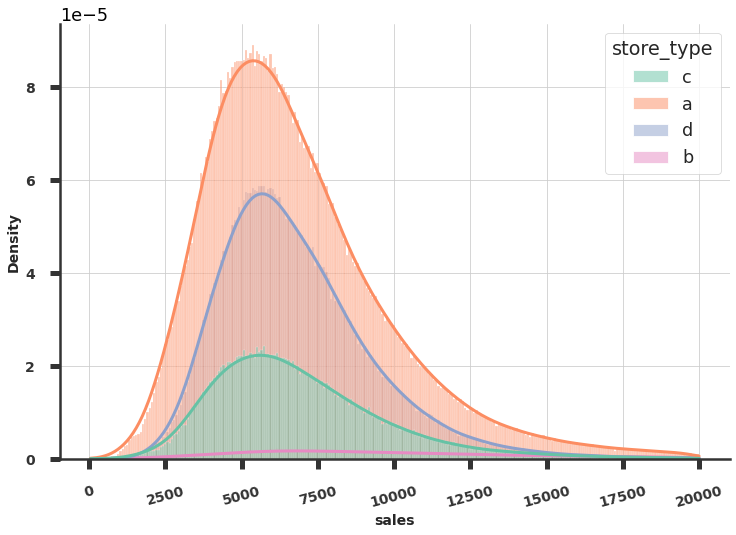

In [255]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots()

sns.histplot(data=df4[(df4['sales'] <=20000)], 
             kde=True, 
             stat='density',
             #common_norm=False,
             x='sales',
             hue='store_type',
             multiple='layer',
             kde_kws={'bw_adjust':2},
             line_kws={'linewidth':3},
             palette='Set2',
             ax=ax)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=15)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/sales_hist.png',
           dpi=400,
           facecolor=ax.get_facecolor())

In [ ]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)
aux = df4[(df4['sales'] <=20000)]
aux1 = aux[['store_type', 'sales']].groupby('store_type').mean().reset_index()


fig, ax = plt.subplots()

sns.barplot(data=aux1, 
            x='store_type',
            y='sales',
            palette='Set2',
            capsize=0.5,
            edgecolor='0.2',
            lw=2.5,
            ax=ax);

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=15)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/store_type_sales_barplot.png',
           dpi=400,
           facecolor=ax.get_facecolor())

In [ ]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

aux = df4[(df4['sales'] <=20000)]
aux1 = aux[['store_type', 'sales']].groupby('store_type').mean().reset_index()

fig, ax = plt.subplots()

sns.boxplot(data=df4, 
            x='store_type',
            y='sales',
            palette='Set2',
            ax=ax)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=15)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/store_type_sales_boxplot.png',
           dpi=400,
           facecolor=ax.get_facecolor())

In [ ]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df4.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])

In [ ]:

first_column = num_attributes.pop('sales')
  
# insert column using insert(position,column_name,
# first_column) function
num_attributes.insert(0, 'sales', first_column)


In [ ]:
num_attributes.columns


In [ ]:
correlation = num_attributes[num_attributes['sales'] <=20000].corr(method='pearson')

In [ ]:
irrelevant_fields = ['Unnamed: 0', 'store',
       'competition_open_since_month', 'competition_open_since_year',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week']

In [ ]:
correlation.drop(irrelevant_fields, inplace=True)
correlation.drop(irrelevant_fields, axis=1, inplace=True)

In [ ]:
correlation

In [ ]:
sns.set_style('white')
sns.set_context('paper', font_scale=1.0)
pd.options.display.float_format = '{:.3f}'.format

aux = df4[(df4['sales'] <=20000)]
aux1 = aux[['store_type', 'sales']].groupby('store_type').mean().reset_index()

fig, ax = plt.subplots()

mask = np.triu(np.ones_like(correlation, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = correlation.iloc[1:,:-1].copy()

sns.heatmap(corr, 
            annot=True,
            cmap="Blues",
           vmin=-1.0,
           vmax=1.0, 
           linewidth=0.3,
           cbar_kws={"shrink":1, 'drawedges':True, 'aspect':20},
           square=False,
           mask=mask,
           fmt=".3f",
           robust=True,
           annot_kws={'fontsize':12, 'fontweight':'bold', 'fontstyle':'normal', 'color':'black', 'alpha':1.0, 'rotation':'horizontal','verticalalignment':'center'})

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=90)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/store_type_sales_heatmap.png',
           dpi=400,
           facecolor=ax.get_facecolor())

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

sns.set_style('white')
sns.set_context('paper', font_scale=1.0)
pd.options.display.float_format = '{:.3f}'.format

fig, ax = plt.subplots()

mask = np.triu(np.ones_like(d, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = d.iloc[1:,:-1].copy()

sns.heatmap(corr, 
            annot=True,
            cmap="Blues",
           vmin=-1.0,
           vmax=1.0, 
           linewidth=0.3,
           cbar_kws={"shrink":1, 'aspect':20, 'drawedges':True},
           square=True,
           #mask=mask,
           fmt=".3f",
           robust=True,
           annot_kws={'fontsize':12, 'fontweight':'bold', 'fontstyle':'normal', 'color':'black', 'alpha':1.0, 'rotation':'horizontal','verticalalignment':'center'})

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

    
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=90)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/store_type_sales_heatmap_cat.png',
           dpi=400,
           facecolor=ax.get_facecolor())

In [ ]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

fig = plt.figure(figsize=(10,6)) # figsize default = (6.4, 4.8) -> (largura, altura) em inch

# Cada figura individual será um objeto Ax
# Podemos criar um ax especificando (esquerda, inferior, largura, altura) da figura
ax = plt.axes((0.1, 0.1, 0.5, 0.8))

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='x', 
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='red', 
               pad=15, 
               labelsize=15, 
               labelcolor='green', 
               labelrotation=15)

ax.set_xticks([0.2, 1, 3])
ax.set_xticklabels(['pos1', 'pos2', 'pos3'])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.grid(True, which='major', axis='both', alpha=1)

c = ax.get_xticks()
d = ax.get_xticklabels()

In [ ]:
fig, axes = plt.subplots(nrows=4, 
                         ncols=4, 
                         figsize=(10,6),
                         gridspec_kw={
                             'wspace': 0.5, 
                             'hspace': 0.5})

In [ ]:
# prepare some data
np.random.seed(42)
x = np.arange(1,11,1)
y1 = np.linspace(300,400,10)
y2 = np.random.randint(low=300,high=400,size=10)

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.8])
#ax.plot(x, y1)

h1 = ax.plot(x,y1, # data
            marker='o',     # each marker will be rendered as a circle
            markersize=8,   # marker size
            markerfacecolor='red',   # marker facecolor
            markeredgecolor='black',  # marker edgecolor
            markeredgewidth=2,       # marker edge width
            linestyle='--',            # line style will be dash line
            linewidth=3,
            zorder=3)          # line width

h2 = ax.plot(x, y2, marker='o')

ax.legend(handles=[h1[0], h2[0]], 
          labels=['blue line', 'orange line'],
          loc='upper left',
         bbox_to_anchor=(1,1),
         title='legend',
         frameon=False)

for flier in bp['fliers']:    # outliers
    flier.set_markersize(9)
    flier.set_marker('v')
for box in bp['boxes']:     # box bodys
    box.set_facecolor('green')
    box.set_edgecolor('black')
    box.set_linewidth(2)
for whisker in bp['whiskers']:   # whisker line
    whisker.set_linewidth(5)
for cap in bp['caps']:     # cap line
    cap.set_color('red')
    cap.set_linewidth(10)
for median in bp['medians']:   # median line
    median.set_linewidth(15)

# 5.0 Preparação dos Dados

In [ ]:
df5 = df4.copy()

df5.to_csv(home_path+interim_data_path+'df5.csv')

#df5 = load_csv(home_path+interim_data_path+'df5.csv')

## 5.1 Normalização

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open(home_path+'models' + '/' +'parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs, open(home_path + 'models' + '/' + 'parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open(home_path + 'models' + '/' + 'parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open(home_path + 'models' + '/' + 'parameter/year_scaler.pkl', 'wb'))

## 5.2 Padronização


## 5.3  Transformação

### 5.3.1 Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open(home_path + 'models' + '/' + 'parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da Variável Resposta

In [ ]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Tranformação de Natureza Cíclica

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. *np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. *np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52 )))

# 6.0 Feature Selection

In [20]:
#df6 = df5.copy()

#df6.to_csv(home_path+interim_data_path+'df6.csv')

df6 = load_csv(home_path+interim_data_path+'df6.csv')

## 6.1 Divisão do conjunto de dados 

In [21]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [22]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01
Training Max Date: 2015-06-18

Test Min Date: 2015-06-19
Test Max Date: 2015-07-31


## 6.2. Boruta como Seletor de Variáveis

In [ ]:
# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Melhores variáveis segundo o Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3 Seleção Manual de Variáveis

In [23]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Modelar Algoritmos de ML

In [24]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

In [25]:
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Modelo de Média

In [16]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Modelo de Regressão Linear

In [17]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1866.162909,0.292555,2671.235745


### 7.2.1 Cross-Validation - Modelo de Regressão Linear

In [18]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

NameError: name 'cross_validation' is not defined

## 7.3 Modelo de Regressão Regularizado - Lasso

In [19]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.266181,0.289061,2744.602221


### 7.3.1. Lasso - Cross Validation

In [3]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

NameError: name 'x_training' is not defined

## 7.4 Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv

## 7.6. Compare Model’s Performance

### 7.6.1. Single Performance

In [7]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

NameError: name 'pd' is not defined

### 7.6.2. Real Performance - Cross Validation

In [8]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

NameError: name 'pd' is not defined

# 8.0 Hyperparamenter Fine Tuning

## 8.1 Random Search

In [ ]:
param = {
 'n_estimators': [1500, 1700, 2500, 3000, 3500],
 'eta': [0.01, 0.03],
 'max_depth': [3, 5, 9],
 'subsample': [0.1, 0.5, 0.7],
 'colsample_bytree': [0.3, 0.7, 0.9],
 'min_child_weight': [3, 8, 15]
 }

MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )

    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytee=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )
    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )

final_result

In [ ]:
final_result

## 8.2 Modelo Final

In [26]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
    }

In [28]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.975639,0.114861,1100.725149


In [31]:
pickle.dump(model_xgb_tuned, open(home_path + 'models' + '/' + 'model_final/model_rossmann.pkl', 'wb'))

In [37]:
range_y_test = np.expm1( y_test ).max() - np.expm1( y_test ).min()
range_y_test

40981.99999999998

In [38]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

mpe

-0.017594924431520973

# 9.0 Tradução e Interpretação do Erro

In [39]:
## aqui só vou pegar algumas colunas do boruta_full
df9 = X_test[cols_selected_boruta_full]

df9.to_csv(home_path+interim_data_path+'df9.csv')

#df9 = load_csv(home_path+interim_data_path+'df9.csv')

In [40]:
# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/tmp/ipykernel_711000/2428875374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
/tmp/ipykernel_711000/2428875374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 Performance de Negócio

In [41]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

In [42]:
df92.head()

,store,predictions,MAE,MAPE
0,1,168687.343750,312.836663,0.072395
1,2,181478.250000,437.644947,0.087774
2,3,264653.250000,607.568584,0.084043
3,4,346129.093750,853.454946,0.081535
4,5,173316.078125,399.381750,0.090586


In [56]:
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAPE']*df92['predictions']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']*df92['predictions']

pd.options.display.float_format = '{:,.2f}'.format

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [57]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
126,127,"199,641.52","173,261.07","226,021.96",718.11,0.13
159,160,"220,203.03","201,771.24","238,634.82",456.51,0.08
879,880,"283,334.44","259,727.34","306,941.54",708.35,0.08
440,441,"233,006.69","211,117.72","254,895.66",619.01,0.09
1086,1087,"236,658.80","217,400.08","255,917.52",545.73,0.08


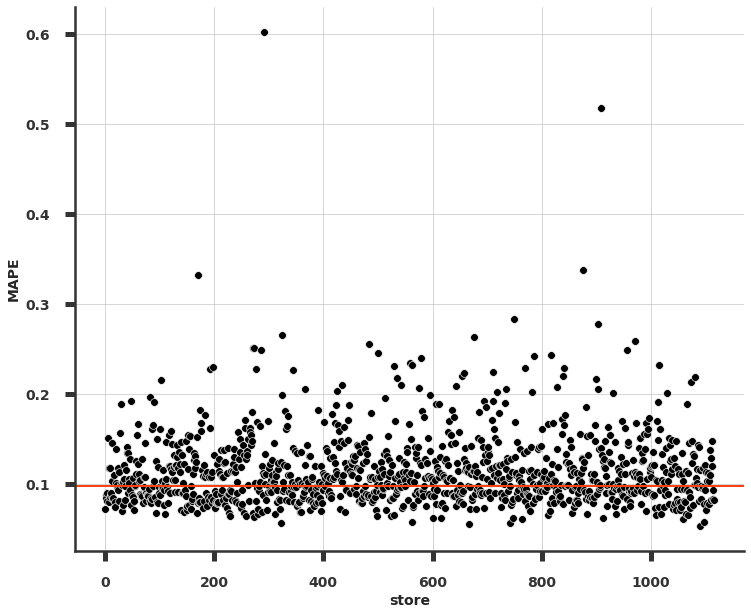

In [107]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots()

sns.scatterplot(x='store', 
                y='MAPE', 
                data=df92,
                s=60,
                color='#000000',
                alpha=1)

plt.axhline(0.0975, 
            linestyle='-',
            color='#FE420F',
            alpha=1,
           linewidth=2.0
           )

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/mape-store-scatter.png',
           dpi=400,
           facecolor=ax.get_facecolor())

## 9.2 Performance Total

In [108]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$286,435,616.00"
1,worst_scenario,"R$254,255,718.50"
2,best_scenario,"R$318,615,492.78"


## 9.3 Perfomance do Modelo de Machine Learning

In [109]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_711000/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_711000/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/tmp/ipykernel_711000/3855581706.py:36: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, which='major', axis='both', alpha=1)


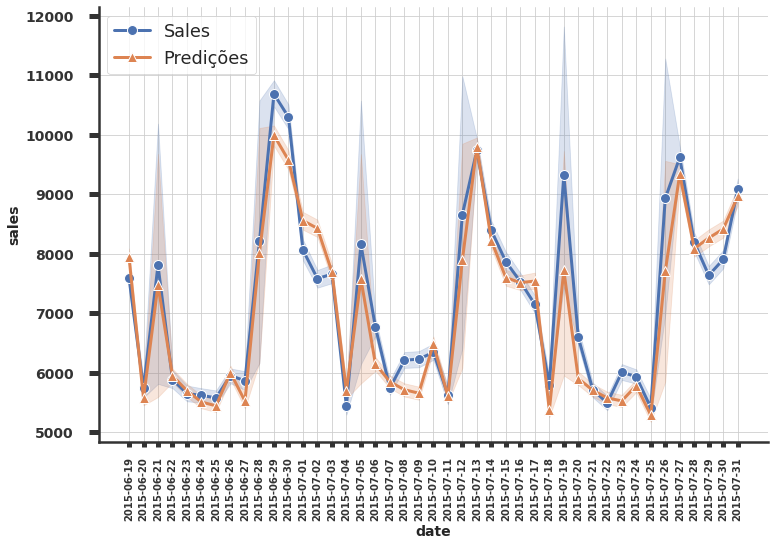

In [157]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots()

aux = df9.sort_values('date', ascending=True)

sns.lineplot(x='date',
             y='sales', 
             data=aux, 
             label='Sales',
             marker='o',
             markeredgewidth=1,
             markersize=10,
             linewidth=3)

sns.lineplot(x='date',
             y='predictions', 
             data=aux, 
             label='Predições',
             marker='^',
             markeredgewidth=1,
             markersize=10,
             linewidth=3)


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='upper left')

ax.grid(False, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=5, 
               width=5,
               color='0.2', 
               pad=10, 
               labelsize=10, 
               labelcolor='black', 
               labelrotation=90)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=10, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/sales-predictions.png',
           dpi=400,
           facecolor=ax.get_facecolor())

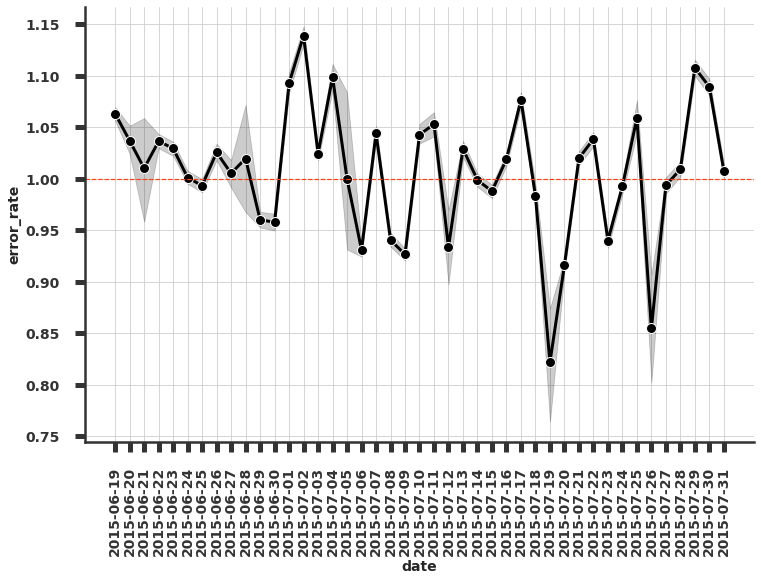

In [164]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots()

aux = df9.sort_values('date', ascending=True)

sns.lineplot(x='date', 
             y='error_rate', 
             data=aux,
             marker='o',
             markeredgewidth=1,
             markersize=10,
             linewidth=3,
            color='#000000')

plt.axhline(1, linestyle='--', color='#FE420F' )


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=90)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/error-rate-superestimar.png',
           dpi=400,
           facecolor=ax.get_facecolor())

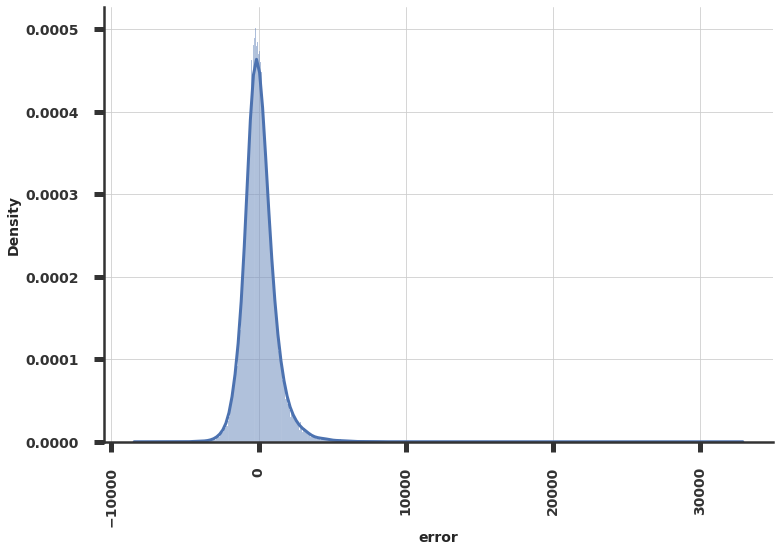

In [177]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots()

sns.histplot(df9,
             kde=True, 
             stat='density',
             #common_norm=False,
             x='error',
             kde_kws={'bw_adjust':2},
             line_kws={'linewidth':3},
             palette='Set2',
             ax=ax)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=90)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/error-distribution.png',
            dpi=400,
            facecolor=ax.get_facecolor())

/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


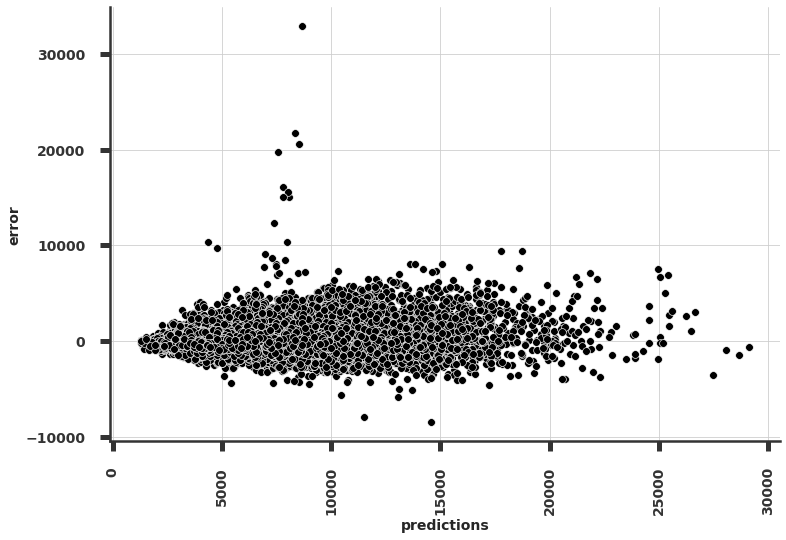

In [179]:
sns.set_style('white')
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots()

sns.scatterplot(df9['predictions'], 
                df9['error'],
                data=df92,
                s=60,
                color='#000000',
                alpha=1)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.grid(True, which='major', axis='both', alpha=1)

ax.tick_params(axis='x', 
               bottom=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5,
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=90)

ax.tick_params(axis='y', 
               left=True,
               which='major', 
               direction='out', 
               length=10, 
               width=5, 
               color='0.2', 
               pad=15, 
               labelsize=15, 
               labelcolor='black', 
               labelrotation=0)

ax.set_xlabel(ax.get_xlabel(), fontsize=14, weight='bold')
ax.set_ylabel(ax.get_ylabel(), fontsize=14, weight='bold')


plt.xticks(size=14, weight='bold', color = '0.2')
plt.yticks(size=14, weight='bold', color = '0.2')


plt.savefig('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/reports/figures/prediction-error-distribution.png',
            dpi=400,
            facecolor=ax.get_facecolor())

# 10. Deploy do Modelo para Produção

In [ ]:
pickle.dump(model_xgb_tuned, open(home_path + 'models' + '/' + 'model_final/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [184]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path ='/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/'
        self.competition_distance_scaler = pickle.load(open( self.home_path + 'models/parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'models/parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'models/parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load( open( self.home_path + 'models/parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load( open( self.home_path + 'models/parameter/store_type_scaler.pkl', 'rb') )

    def data_cleaning(self, df1):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 
                    'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance',
                    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        
        # 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(
            lambda x: 200000.0 if math.isnan( x ) else x )
        
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(
            lambda x: x['date'].month if math.isnan(
                x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
        
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(
                x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
        
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(
            lambda x: x['date'].week if math.isnan(
                x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
        
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(
                x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval
        month_map = {
            1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        
        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        return df1
    
    
    
    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply(
            lambda x: datetime.datetime(
                year=x['competition_open_since_year'], 
                month=x['competition_open_since_month'], 
                day=1), axis=1)
        
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else'christmas' if x == 'c' else 'regular_day' )
        
        
        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]
        
        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    
    
    def data_preparation(self, df5):
        
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(
            df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(
            df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(
            df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )
        
        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'] )
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 
                         'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week',
                         'promo2_since_year', 'competition_time_month', 'promo_time_week',
                         'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                         'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        
        return df5[ cols_selected ]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict( test_data )
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        return original_data.to_json(orient='records', date_format='iso')
        

## 10.2 API Handler

In [205]:
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open(
    '/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/models/model_final/model_rossmann.pkl', 'rb') )

# Inicializa a API
app = Flask(__name__)

@app.route('rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        pipeline = Rossmann()
        
        df1 = pipeline.data_cleaning(test_raw)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_preparation(df2)
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    else: 
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [277]:
df10 = pd.read_csv('/home/sildolfoneto/Documents/repos/tcc/rossmann-stores-sales/data/raw/test.csv')

df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [270]:
data = json.dumps( df_test.to_dict( orient='records' ) )

In [283]:
data

'[{"Store": 12, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 1070.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 13.0, "Promo2SinceYear": 2010.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 24, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 4590.0, "CompetitionOpenSinceMonth": 3.0, "CompetitionOpenSinceYear": 2000.0, "Promo2": 1, "Promo2SinceWeek": 

In [284]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-store-sales.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [285]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [286]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,extended,"1,070.00",9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,"6,523.37"
1,22,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,basic,"1,040.00",9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,"4,619.05"
2,24,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,extended,"4,590.00",3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,"12,737.18"
3,12,3,2015-09-16T00:00:00.000Z,1.00,1,regular_day,0,a,extended,"1,070.00",9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,"6,594.04"
4,22,3,2015-09-16T00:00:00.000Z,1.00,1,regular_day,0,a,basic,"1,040.00",9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,"4,682.25"


In [287]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'A loja {} irá vender R${:,.2f} nas próximas 6 semanas.'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

A loja 12 irá vender R$272,456.77 nas próximas 6 semanas.
A loja 22 irá vender R$187,162.12 nas próximas 6 semanas.
A loja 24 irá vender R$502,426.32 nas próximas 6 semanas.
